In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241947 entries, 0 to 2241946
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 34.2 MB


# reduce to 1 million events

In [4]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [5]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,19949,0.18,19.949
1,19956,0.18,19.956
2,20125,0.18,20.125
3,20288,0.18,20.288
4,20380,0.18,20.380
...,...,...,...
999995,21533,0.17,21.533
999996,21787,0.17,21.787
999997,21892,0.16,21.892
999998,21451,0.17,21.451


In [6]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [7]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [8]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26052843274000

### Calcul de la date de base = now - cumul_interval

In [9]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 7, 25, 8, 46, 32, 911703)

In [10]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [11]:
conso_data.iloc[0]


Interval     19949.000000
kWh              0.180000
sec             19.949000
Wh             180.460173
cumul(ms)    19949.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [12]:
base

datetime.datetime(2024, 7, 25, 8, 46, 32, 911703)

## créer les dates

In [13]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-07-25 08:46:52.860703
1        2024-07-25 08:47:12.816703
2        2024-07-25 08:47:32.941703
3        2024-07-25 08:47:53.229703
4        2024-07-25 08:48:13.609703
                    ...            
999995   2025-05-22 21:39:09.033703
999996   2025-05-22 21:39:30.820703
999997   2025-05-22 21:39:52.712703
999998   2025-05-22 21:40:14.163703
999999   2025-05-22 21:40:36.185703
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [14]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,19949,0.18,19.949,180.460173,19949,2024-07-25 08:46:52.860703,25/07/24
1,19956,0.18,19.956,180.396873,39905,2024-07-25 08:47:12.816703,25/07/24
2,20125,0.18,20.125,178.881988,60030,2024-07-25 08:47:32.941703,25/07/24
3,20288,0.18,20.288,177.444795,80318,2024-07-25 08:47:53.229703,25/07/24
4,20380,0.18,20.380,176.643768,100698,2024-07-25 08:48:13.609703,25/07/24
...,...,...,...,...,...,...,...
999995,21533,0.17,21.533,167.185251,26052756122,2025-05-22 21:39:09.033703,22/05/25
999996,21787,0.17,21.787,165.236150,26052777909,2025-05-22 21:39:30.820703,22/05/25
999997,21892,0.16,21.892,164.443632,26052799801,2025-05-22 21:39:52.712703,22/05/25
999998,21451,0.17,21.451,167.824344,26052821252,2025-05-22 21:40:14.163703,22/05/25


### save conso_data with dates

In [15]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [16]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('22/05/25', 22, 5, 2025, '21:40:53')

In [17]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [18]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2940 entries, 997060 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2940 non-null   int64         
 1   kWh        2940 non-null   float64       
 2   sec        2940 non-null   float64       
 3   Wh         2940 non-null   float64       
 4   cumul(ms)  2940 non-null   int64         
 5   dates      2940 non-null   datetime64[ns]
 6   days       2940 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 183.8+ KB


In [19]:
end = time.time()
print(end - start)

19.33205246925354


### grouped by days

In [20]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [21]:
data = list(df_grp['kWh'])
print(data)

[2.253, 3.249, 3.202, 2.846, 3.054, 3.201, 4.193, 3.876, 2.997, 3.321, 3.343, 3.512, 3.643, 3.491, 3.684, 3.723, 3.922, 3.652, 4.378, 4.316, 3.911, 3.875, 4.043, 3.778, 3.866, 3.704, 3.286, 3.92, 3.955, 4.376, 3.844, 4.105, 3.798, 3.974, 3.75, 3.981, 3.657, 3.656, 3.494, 3.683, 3.503, 4.147, 3.714, 3.442, 3.564, 3.223, 2.473, 1.795, 1.792, 1.794, 1.795, 2.474, 1.864, 1.788, 1.791, 1.79, 1.821, 1.822, 1.815, 1.817, 1.818, 1.818, 1.815, 1.814, 1.785, 1.786, 1.785, 1.787, 1.782, 1.797, 1.788, 1.79, 1.785, 1.795, 1.803, 1.795, 1.804, 1.795, 1.786, 1.789, 1.785, 1.791, 1.797, 1.791, 1.8, 1.804, 1.794, 1.8, 1.798, 2.777, 3.999, 3.657, 3.898, 3.105, 3.542, 4.048, 3.431, 3.37, 3.983, 3.341, 4.167, 3.088, 4.033, 3.154, 3.348, 3.474, 4.014, 3.289, 3.372, 3.824, 3.226, 3.526, 3.363, 3.875, 3.338, 3.439, 3.702, 4.467, 3.646, 3.844, 3.452, 4.101, 3.498, 3.413, 3.439, 3.734, 3.734, 4.067, 3.546, 3.468, 3.704, 3.161, 3.684, 3.745, 3.33, 3.841, 3.258, 4.04, 3.393, 3.836, 3.98, 3.473, 4.476, 3.205, 3.5

In [22]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [23]:
end = time.time()
print(end - start)

19.630176067352295


### plot function by day
#### show('dd/mm/yy')

In [24]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


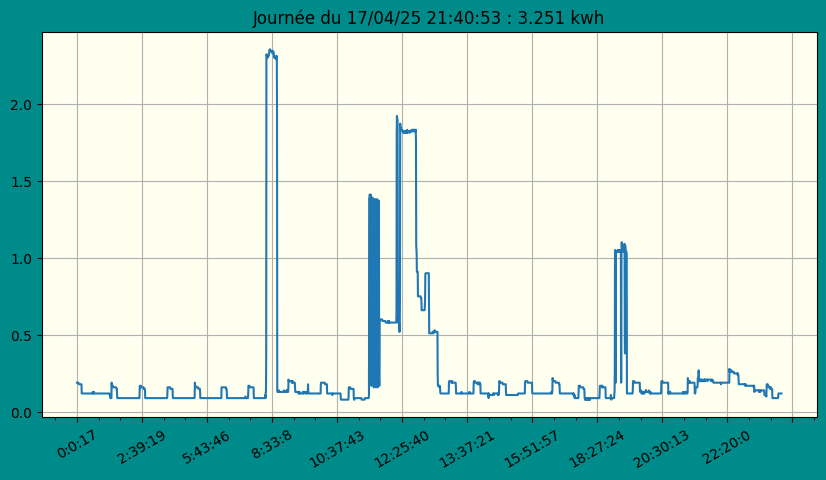

In [25]:
show('17/04/25')

In [26]:
end = time.time()
print(end - start)

21.13819193840027


### 1 kWh window in data of one day
#### df = conso_day

In [27]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997060,17722,0.20,17.722,203.137343,25974814539,2025-05-22 00:00:07.450703,22/05/25
997061,17944,0.20,17.944,200.624164,25974832483,2025-05-22 00:00:25.394703,22/05/25
997062,17909,0.20,17.909,201.016249,25974850392,2025-05-22 00:00:43.303703,22/05/25
997063,17487,0.20,17.487,205.867216,25974867879,2025-05-22 00:01:00.790703,22/05/25
997064,17446,0.21,17.446,206.351026,25974885325,2025-05-22 00:01:18.236703,22/05/25
...,...,...,...,...,...,...,...
999995,21533,0.17,21.533,167.185251,26052756122,2025-05-22 21:39:09.033703,22/05/25
999996,21787,0.17,21.787,165.236150,26052777909,2025-05-22 21:39:30.820703,22/05/25
999997,21892,0.16,21.892,164.443632,26052799801,2025-05-22 21:39:52.712703,22/05/25
999998,21451,0.17,21.451,167.824344,26052821252,2025-05-22 21:40:14.163703,22/05/25


In [28]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [29]:
df = conso_day
len(df)

2940

In [30]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-05-22 00:00:07.450703	2025-05-22 08:16:25.115703	8h 16m 17s 	1000
2025-05-22 08:16:25.115703	2025-05-22 13:33:45.665703	5h 17m 20s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.30251
dtype: float64

In [32]:
end = time.time()
print(end - start)

21.450867652893066


## mean for data grouped by days

In [33]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.311258
dtype: float64

In [34]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.94)

# conso by date


In [35]:
# select day
day = today

#day = '16/08/24'
day

'22/05/25'

In [36]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997060,17722,0.20,17.722,203.137343,25974814539,2025-05-22 00:00:07.450703,22/05/25
997061,17944,0.20,17.944,200.624164,25974832483,2025-05-22 00:00:25.394703,22/05/25
997062,17909,0.20,17.909,201.016249,25974850392,2025-05-22 00:00:43.303703,22/05/25
997063,17487,0.20,17.487,205.867216,25974867879,2025-05-22 00:01:00.790703,22/05/25
997064,17446,0.21,17.446,206.351026,25974885325,2025-05-22 00:01:18.236703,22/05/25
...,...,...,...,...,...,...,...
999995,21533,0.17,21.533,167.185251,26052756122,2025-05-22 21:39:09.033703,22/05/25
999996,21787,0.17,21.787,165.236150,26052777909,2025-05-22 21:39:30.820703,22/05/25
999997,21892,0.16,21.892,164.443632,26052799801,2025-05-22 21:39:52.712703,22/05/25
999998,21451,0.17,21.451,167.824344,26052821252,2025-05-22 21:40:14.163703,22/05/25


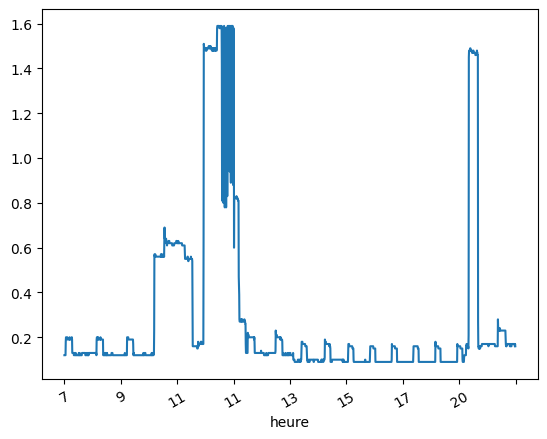

In [37]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [38]:
end = time.time()
print(end - start)

22.48737144470215


### grouped by 'heure'

In [39]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2940 entries, 997060 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2940 non-null   int64         
 1   kWh        2940 non-null   float64       
 2   sec        2940 non-null   float64       
 3   Wh         2940 non-null   float64       
 4   cumul(ms)  2940 non-null   int64         
 5   dates      2940 non-null   datetime64[ns]
 6   days       2940 non-null   object        
 7   heure      2940 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 206.7+ KB


In [40]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997060,17722,0.20,17.722,203.137343,25974814539,2025-05-22 00:00:07.450703,22/05/25
997061,17944,0.20,17.944,200.624164,25974832483,2025-05-22 00:00:25.394703,22/05/25
997062,17909,0.20,17.909,201.016249,25974850392,2025-05-22 00:00:43.303703,22/05/25
997063,17487,0.20,17.487,205.867216,25974867879,2025-05-22 00:01:00.790703,22/05/25
997064,17446,0.21,17.446,206.351026,25974885325,2025-05-22 00:01:18.236703,22/05/25
...,...,...,...,...,...,...,...
999995,21533,0.17,21.533,167.185251,26052756122,2025-05-22 21:39:09.033703,22/05/25
999996,21787,0.17,21.787,165.236150,26052777909,2025-05-22 21:39:30.820703,22/05/25
999997,21892,0.16,21.892,164.443632,26052799801,2025-05-22 21:39:52.712703,22/05/25
999998,21451,0.17,21.451,167.824344,26052821252,2025-05-22 21:40:14.163703,22/05/25


In [41]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [42]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     135
1     107
2     103
3     103
4     102
5     101
6     176
7     133
8     137
9     132
10    202
11    368
12    139
13    110
14    109
15    101
16     99
17     98
18     98
19     98
20    166
21    123
Name: kWh, dtype: int64

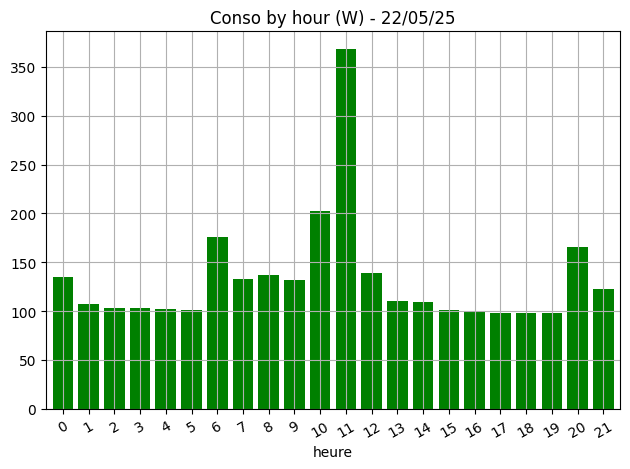

In [43]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [44]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 25/07/24 to 22/05/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     302 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [45]:
# give the periods of 1 kwh in a day
period()

2025-05-22 00:00:07.450703	2025-05-22 08:16:25.115703	8h 16m 17s 	1000


In [46]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [47]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [48]:
df_grp.mean()


kWh    3.311258
dtype: float64

In [49]:
df_grp.head()


,kWh
days,
25/07/24,2.253
26/07/24,3.249
27/07/24,3.202
28/07/24,2.846
29/07/24,3.054


In [50]:
df_grp.tail()


,kWh
days,
18/05/25,2.634
19/05/25,3.296
20/05/25,2.998
21/05/25,3.016
22/05/25,2.940


In [51]:
end = time.time()
print(end - start)

24.057931423187256


# plot les 100 derniers jours


In [52]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.4023
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

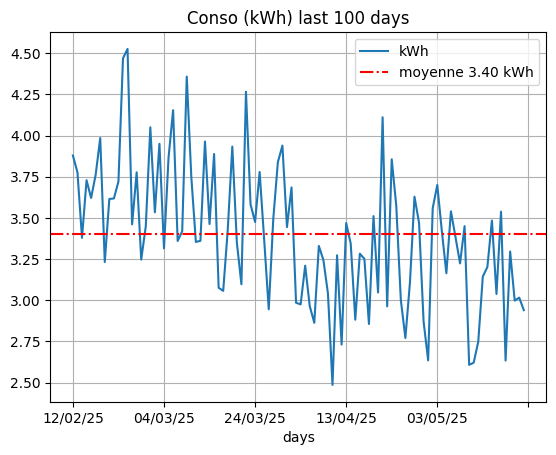

In [53]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [54]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.486
max,4.526


In [55]:
end = time.time()
print(end - start)

24.979795932769775


In [56]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('22/04/25', '17/05/25')

In [57]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.1882
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

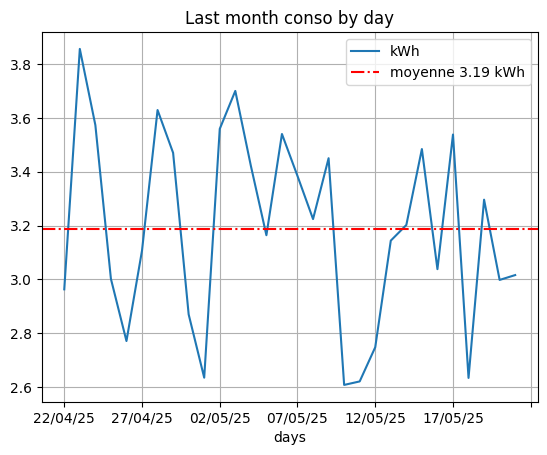

In [58]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [59]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/04/25 3.856
Min : 10/05/25 2.608


# Temps de conso par tranche de 1 kWh

In [60]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


3
2025-05-22 00:00:07.450703	2025-05-22 08:16:25.115703	8h 16m 17s 	1000
2025-05-22 08:16:25.115703	2025-05-22 13:33:45.665703	5h 17m 20s 	2000
2025-05-22 13:33:45.665703	2025-05-22 21:40:36.185703	8h 6m 50s 	940


In [61]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('21:40:53', 2.94, 2940)

In [62]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2940 entries, 997060 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2940 non-null   int64         
 1   kWh        2940 non-null   float64       
 2   sec        2940 non-null   float64       
 3   Wh         2940 non-null   float64       
 4   cumul(ms)  2940 non-null   int64         
 5   dates      2940 non-null   datetime64[ns]
 6   days       2940 non-null   object        
 7   heure      2940 non-null   object        
 8   hours      2940 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 229.7+ KB


In [63]:
conso_hours['heure'], conso_hours['hours']

(997060     0
 997061     0
 997062     0
 997063     0
 997064     0
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: heure, Length: 2940, dtype: object,
 997060    00
 997061    00
 997062    00
 997063    00
 997064    00
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: hours, Length: 2940, dtype: object)

In [64]:
end = time.time()
print(end - start)

25.891950368881226


# select number of days to display


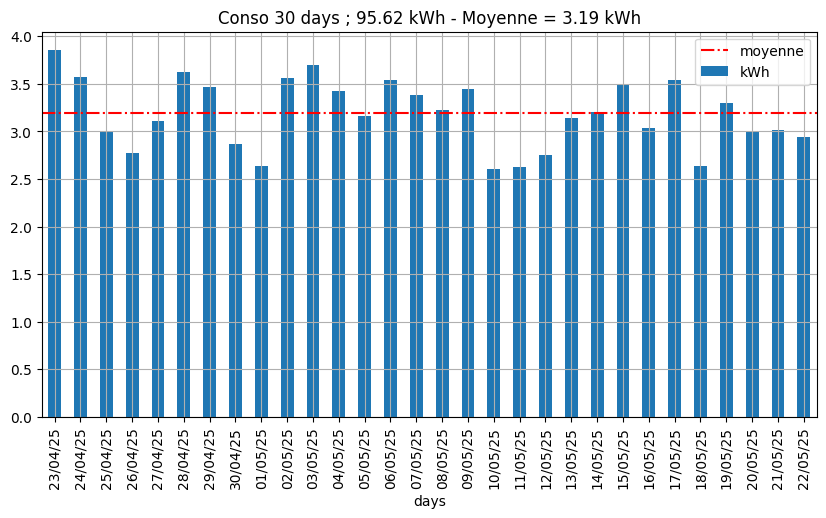

In [65]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


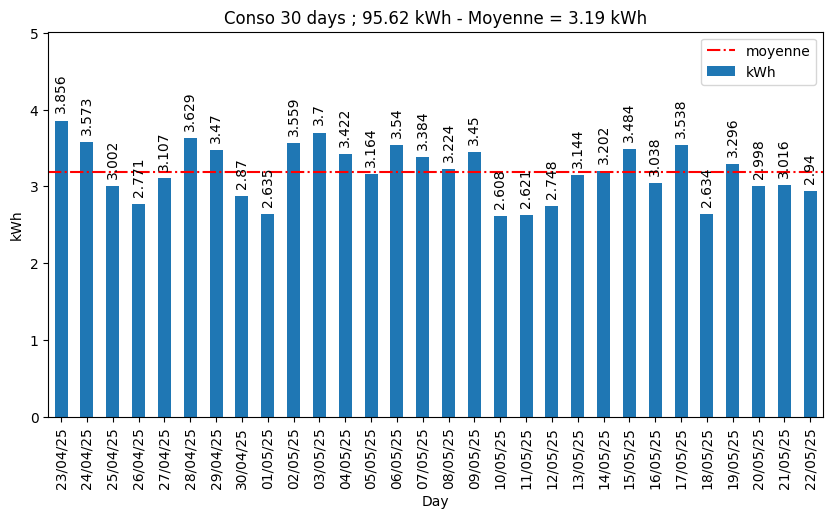

In [66]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [67]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
23/04/25    3.856
24/04/25    3.573
25/04/25    3.002
26/04/25    2.771
27/04/25    3.107
28/04/25    3.629
29/04/25    3.470
30/04/25    2.870
01/05/25    2.635
02/05/25    3.559
03/05/25    3.700
04/05/25    3.422
05/05/25    3.164
06/05/25    3.540
07/05/25    3.384
08/05/25    3.224
09/05/25    3.450
10/05/25    2.608
11/05/25    2.621
12/05/25    2.748
13/05/25    3.144
14/05/25    3.202
15/05/25    3.484
16/05/25    3.038
17/05/25    3.538
18/05/25    2.634
19/05/25    3.296
20/05/25    2.998
21/05/25    3.016
22/05/25    2.940
Name: kWh, dtype: float64

In [68]:
x_labels=df_grp.tail(span).index
x_labels

Index(['23/04/25', '24/04/25', '25/04/25', '26/04/25', '27/04/25', '28/04/25',
       '29/04/25', '30/04/25', '01/05/25', '02/05/25', '03/05/25', '04/05/25',
       '05/05/25', '06/05/25', '07/05/25', '08/05/25', '09/05/25', '10/05/25',
       '11/05/25', '12/05/25', '13/05/25', '14/05/25', '15/05/25', '16/05/25',
       '17/05/25', '18/05/25', '19/05/25', '20/05/25', '21/05/25', '22/05/25'],
      dtype='object', name='days')

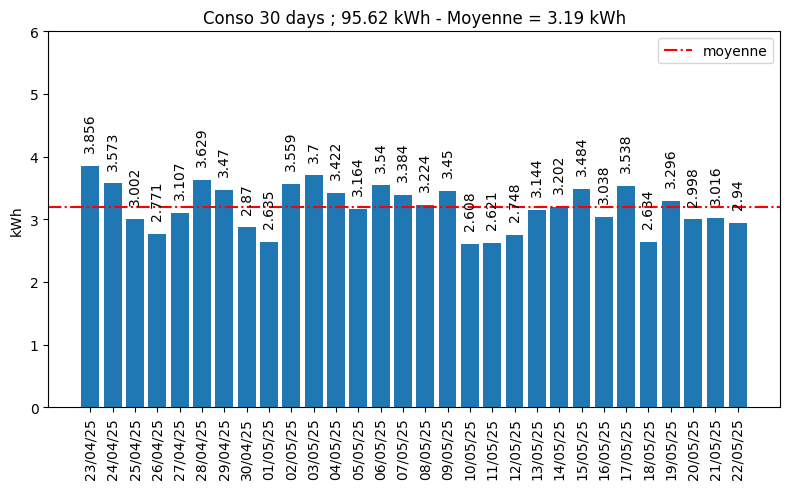

In [69]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [70]:
end = time.time()
print(end - start)

30.44039821624756


In [71]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

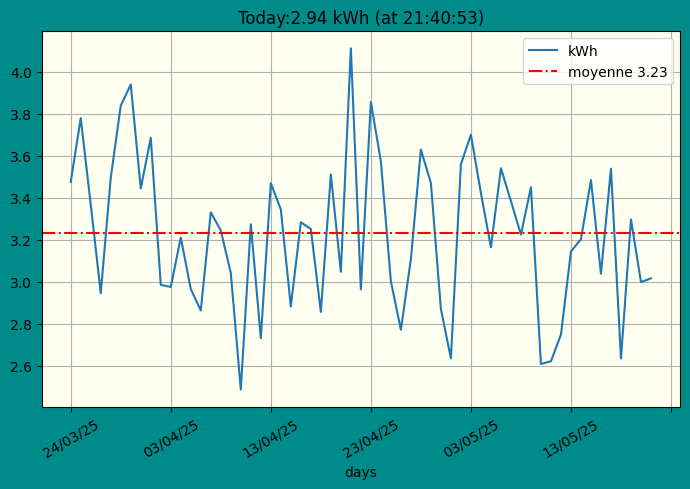

In [72]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

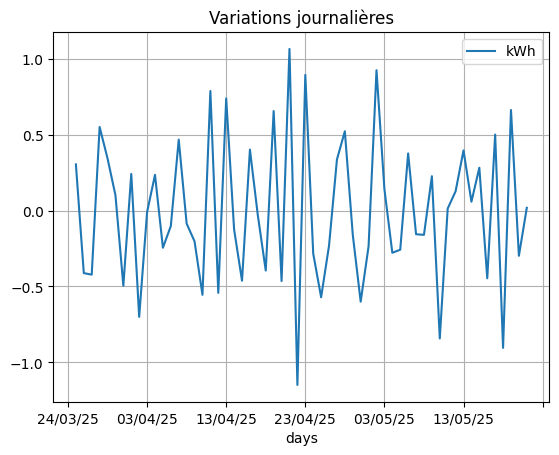

In [73]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [74]:
end = time.time()
print(end - start)

31.670880556106567


# Data from 21/08/23

In [75]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,19949,0.18,19.949,180.460173,19949,2024-07-25 08:46:52.860703,25/07/24,08,2024-07,25
1,19956,0.18,19.956,180.396873,39905,2024-07-25 08:47:12.816703,25/07/24,08,2024-07,25
2,20125,0.18,20.125,178.881988,60030,2024-07-25 08:47:32.941703,25/07/24,08,2024-07,25
3,20288,0.18,20.288,177.444795,80318,2024-07-25 08:47:53.229703,25/07/24,08,2024-07,25
4,20380,0.18,20.380,176.643768,100698,2024-07-25 08:48:13.609703,25/07/24,08,2024-07,25
...,...,...,...,...,...,...,...,...,...,...
999995,21533,0.17,21.533,167.185251,26052756122,2025-05-22 21:39:09.033703,22/05/25,21,2025-05,22
999996,21787,0.17,21.787,165.236150,26052777909,2025-05-22 21:39:30.820703,22/05/25,21,2025-05,22
999997,21892,0.16,21.892,164.443632,26052799801,2025-05-22 21:39:52.712703,22/05/25,21,2025-05,22
999998,21451,0.17,21.451,167.824344,26052821252,2025-05-22 21:40:14.163703,22/05/25,21,2025-05,22


In [76]:
end = time.time()
print(end - start)

70.34437251091003


In [77]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

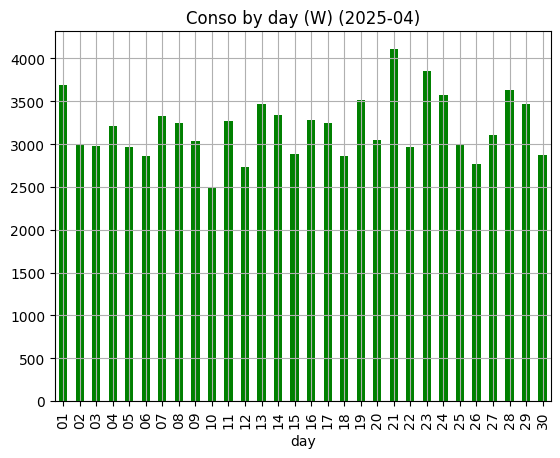

In [78]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [79]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3192.766666666667)

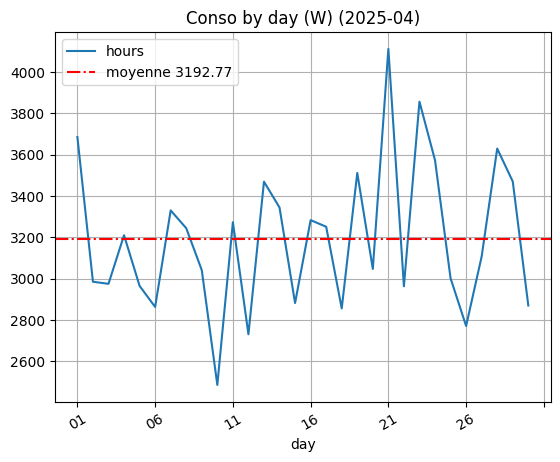

In [80]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [81]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

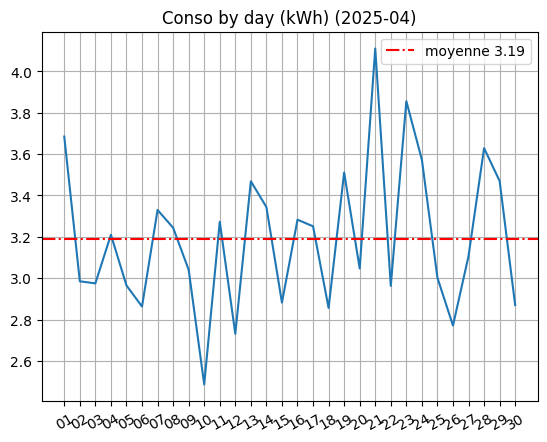

In [82]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [83]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [84]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [85]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-07,21998,21998,21998
2024-08,117337,117337,117337
2024-09,69809,69809,69809
2024-10,73479,73479,73479
2024-11,108514,108514,108514
2024-12,113725,113725,113725
2025-01,113684,113684,113684
2025-02,104470,104470,104470
2025-03,111856,111856,111856


In [86]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [87]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [88]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
25/07/24,2253
26/07/24,3249
27/07/24,3202
28/07/24,2846
29/07/24,3054
...,...
18/05/25,2634
19/05/25,3296
20/05/25,2998


In [89]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,19949,0.18,19.949,180.460173,19949,2024-07-25 08:46:52.860703,25/07/24,08,2024-07,25
1,19956,0.18,19.956,180.396873,39905,2024-07-25 08:47:12.816703,25/07/24,08,2024-07,25
2,20125,0.18,20.125,178.881988,60030,2024-07-25 08:47:32.941703,25/07/24,08,2024-07,25
3,20288,0.18,20.288,177.444795,80318,2024-07-25 08:47:53.229703,25/07/24,08,2024-07,25
4,20380,0.18,20.380,176.643768,100698,2024-07-25 08:48:13.609703,25/07/24,08,2024-07,25
...,...,...,...,...,...,...,...,...,...,...
999995,21533,0.17,21.533,167.185251,26052756122,2025-05-22 21:39:09.033703,22/05/25,21,2025-05,22
999996,21787,0.17,21.787,165.236150,26052777909,2025-05-22 21:39:30.820703,22/05/25,21,2025-05,22
999997,21892,0.16,21.892,164.443632,26052799801,2025-05-22 21:39:52.712703,22/05/25,21,2025-05,22
999998,21451,0.17,21.451,167.824344,26052821252,2025-05-22 21:40:14.163703,22/05/25,21,2025-05,22


In [90]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
25/07/24 08    0       25/07/24    08  0.18
               1       25/07/24    08  0.18
               2       25/07/24    08  0.18
               3       25/07/24    08  0.18
               4       25/07/24    08  0.18
...                         ...   ...   ...
22/05/25 21    999995  22/05/25    21  0.17
               999996  22/05/25    21  0.17
               999997  22/05/25    21  0.16
               999998  22/05/25    21  0.17
               999999  22/05/25    21  0.16

[1000000 rows x 3 columns]

In [91]:
groupallbyday.indices.keys()

dict_keys(['25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/1

In [92]:
groupallbydayhours.indices.keys()

dict_keys([('25/07/24', '08'), ('25/07/24', '09'), ('25/07/24', '10'), ('25/07/24', '11'), ('25/07/24', '12'), ('25/07/24', '13'), ('25/07/24', '14'), ('25/07/24', '15'), ('25/07/24', '16'), ('25/07/24', '17'), ('25/07/24', '18'), ('25/07/24', '19'), ('25/07/24', '20'), ('25/07/24', '21'), ('25/07/24', '22'), ('25/07/24', '23'), ('26/07/24', '08'), ('26/07/24', '09'), ('26/07/24', '10'), ('26/07/24', '11'), ('26/07/24', '12'), ('26/07/24', '13'), ('26/07/24', '14'), ('26/07/24', '15'), ('26/07/24', '16'), ('26/07/24', '17'), ('26/07/24', '18'), ('26/07/24', '19'), ('26/07/24', '20'), ('26/07/24', '21'), ('26/07/24', '22'), ('26/07/24', '23'), ('26/07/24', '00'), ('26/07/24', '01'), ('26/07/24', '02'), ('26/07/24', '03'), ('26/07/24', '04'), ('26/07/24', '05'), ('26/07/24', '06'), ('26/07/24', '07'), ('27/07/24', '08'), ('27/07/24', '09'), ('27/07/24', '10'), ('27/07/24', '11'), ('27/07/24', '12'), ('27/07/24', '13'), ('27/07/24', '14'), ('27/07/24', '15'), ('27/07/24', '16'), ('27/07/2

In [93]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
25/07/24,2253,2253
26/07/24,3249,3249
27/07/24,3202,3202
28/07/24,2846,2846
29/07/24,3054,3054
...,...,...
18/05/25,2634,2634
19/05/25,3296,3296
20/05/25,2998,2998


In [94]:
grp_by_day['kWh'].cumsum()

days
25/07/24       2253
26/07/24       5502
27/07/24       8704
28/07/24      11550
29/07/24      14604
             ...   
18/05/25     987750
19/05/25     991046
20/05/25     994044
21/05/25     997060
22/05/25    1000000
Name: kWh, Length: 302, dtype: int64

In [95]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
25/07/24 08      34
         09     112
         10     112
         11     113
         12     172
...             ...
22/05/25 17      98
         18      98
         19      98
         20     166
         21     123

[7238 rows x 1 columns]

In [96]:
grp_by_dayhours['kWh'].cumsum()

days      hours
25/07/24  08            34
          09           146
          10           258
          11           371
          12           543
                    ...   
22/05/25  17        999515
          18        999613
          19        999711
          20        999877
          21       1000000
Name: kWh, Length: 7238, dtype: int64

In [97]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
25/07/24 08      34      34   NaN
         09     112     146  78.0
         10     112     258   0.0
         11     113     371   1.0
         12     172     543  59.0
...             ...     ...   ...
22/05/25 17      98    2455  -1.0
         18      98    2553   0.0
         19      98    2651   0.0
         20     166    2817  68.0
         21     123    2940 -43.0

[7238 rows x 3 columns]

In [98]:
today, grp_by_dayhours.loc[today]

('22/05/25',
        kWh  cumsum   diff
 hours                    
 00     135     135    NaN
 01     107     242  -28.0
 02     103     345   -4.0
 03     103     448    0.0
 04     102     550   -1.0
 05     101     651   -1.0
 06     176     827   75.0
 07     133     960  -43.0
 08     137    1097    4.0
 09     132    1229   -5.0
 10     202    1431   70.0
 11     368    1799  166.0
 12     139    1938 -229.0
 13     110    2048  -29.0
 14     109    2157   -1.0
 15     101    2258   -8.0
 16      99    2357   -2.0
 17      98    2455   -1.0
 18      98    2553    0.0
 19      98    2651    0.0
 20     166    2817   68.0
 21     123    2940  -43.0)

Text(0.5, 1.0, 'Cumul journalier')

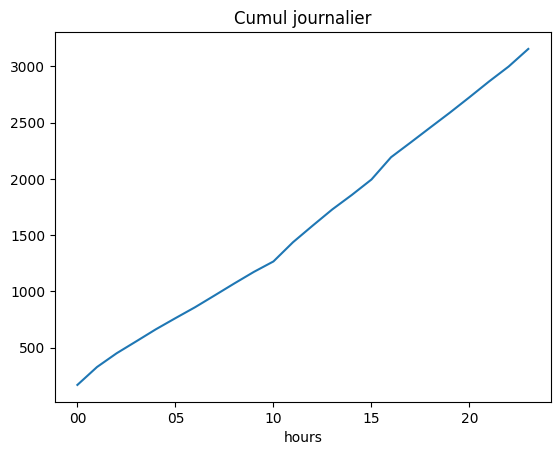

In [99]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

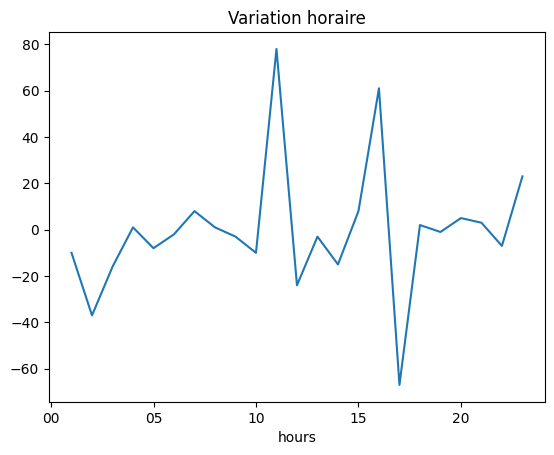

In [100]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [101]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

302

In [102]:
df_grp.tail(n)['kWh'].describe()


count    302.000000
mean       3.311258
std        0.728875
min        1.782000
25%        3.079000
50%        3.439000
75%        3.775500
max        4.885000
Name: kWh, dtype: float64

In [103]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [104]:
n, np.nanmean(df_grp.tail(n))

(302, np.float64(3.3112582781456954))

Text(0.5, 1.0, '302 days')

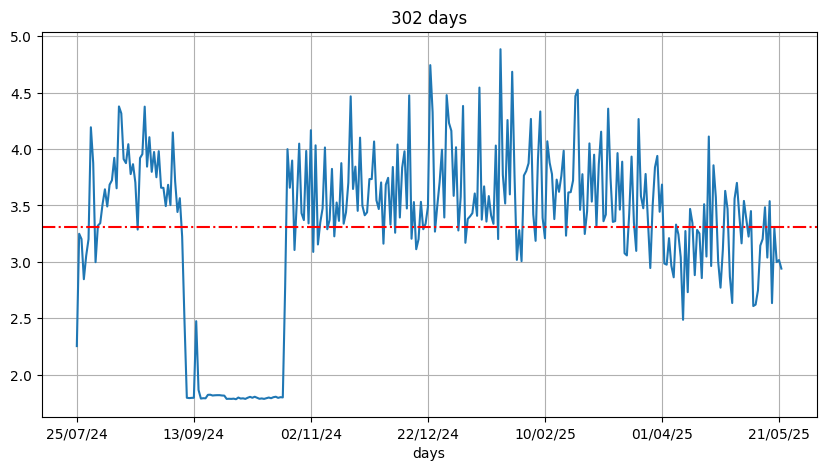

In [105]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

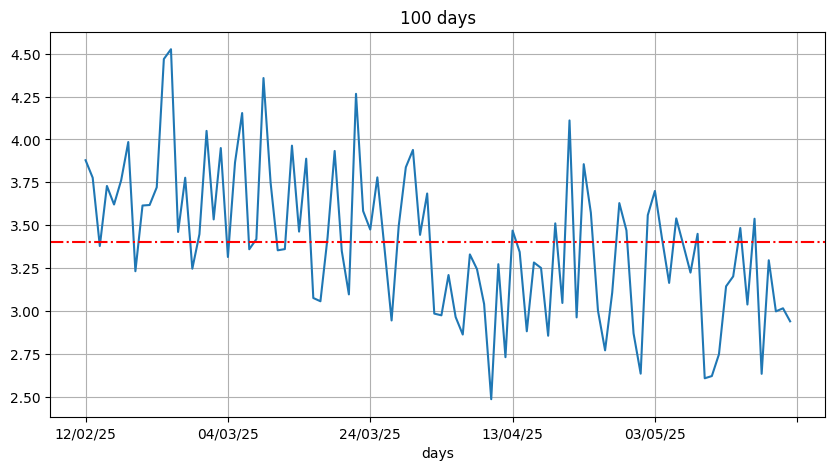

In [106]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [107]:
np.nanmean(df_grp.tail(span))

np.float64(3.4023000000000003)

In [108]:
df_grp['kWh']

days
25/07/24    2.253
26/07/24    3.249
27/07/24    3.202
28/07/24    2.846
29/07/24    3.054
            ...  
18/05/25    2.634
19/05/25    3.296
20/05/25    2.998
21/05/25    3.016
22/05/25    2.940
Name: kWh, Length: 302, dtype: float64

In [109]:
df_grp.describe()

,kWh
count,302.000000
mean,3.311258
std,0.728875
min,1.782000
25%,3.079000
50%,3.439000
75%,3.775500
max,4.885000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

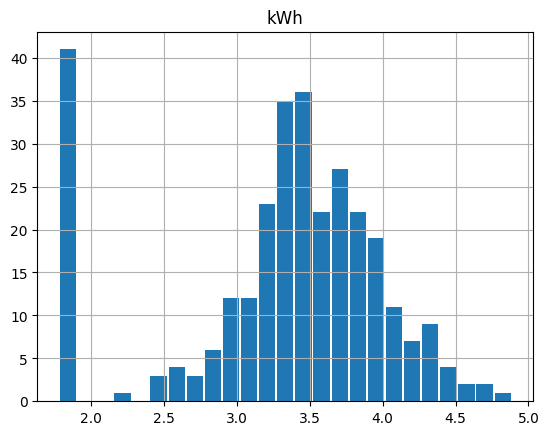

In [110]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [111]:
df_grp.tail(span)['kWh']

days
12/02/25    3.879
13/02/25    3.777
14/02/25    3.379
15/02/25    3.729
16/02/25    3.621
            ...  
18/05/25    2.634
19/05/25    3.296
20/05/25    2.998
21/05/25    3.016
22/05/25    2.940
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [112]:
day

'22/05/25'

In [113]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,135,135,NaN
01,107,242,-28.0
02,103,345,-4.0
03,103,448,0.0
04,102,550,-1.0
05,101,651,-1.0
06,176,827,75.0
07,133,960,-43.0
08,137,1097,4.0


In [114]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


22

In [115]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 23)

In [116]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [117]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [118]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [119]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [120]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 00 to 21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     22 non-null     int64  
 1   cumsum  22 non-null     int64  
 2   diff    21 non-null     float64
 3   days    22 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 880.0+ bytes


In [121]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [122]:
day

'22/05/25'

In [123]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,135,135,NaN,1.0
01,107,242,-28.0,2.0
02,103,345,-4.0,3.0
03,103,448,0.0,4.0
04,102,550,-1.0,5.0
05,101,651,-1.0,6.0
06,176,827,75.0,7.0
07,133,960,-43.0,8.0
08,137,1097,4.0,9.0


In [124]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_12276\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(2940)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '22/05/25: kWh    2940\ndtype: int64')

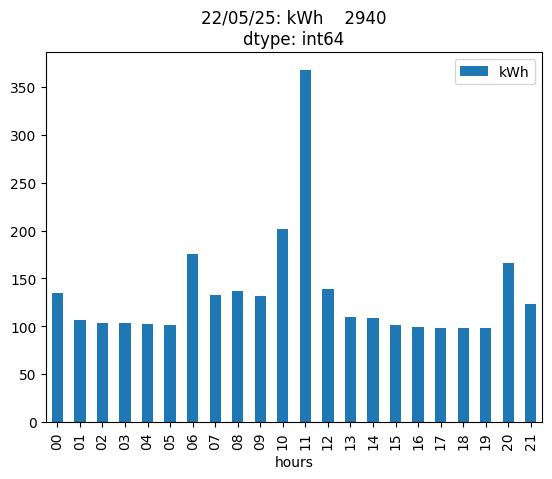

In [125]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [126]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype='object', name='hours')

# Conso du jour


In [127]:

grp_by_dayhours.count()

kWh       7238
cumsum    7238
diff      6936
days        22
dtype: int64

'22/01/25'

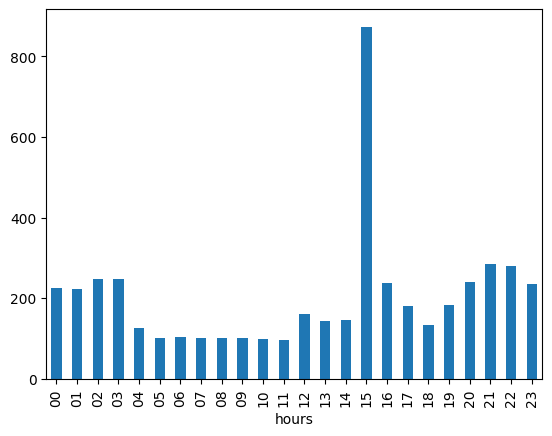

In [128]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [129]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [130]:
df_grp.tail(7)['kWh']

days
16/05/25    3.038
17/05/25    3.538
18/05/25    2.634
19/05/25    3.296
20/05/25    2.998
21/05/25    3.016
22/05/25    2.940
Name: kWh, dtype: float64

Total= 340.23 , Moyenne= 3.4023000000000003


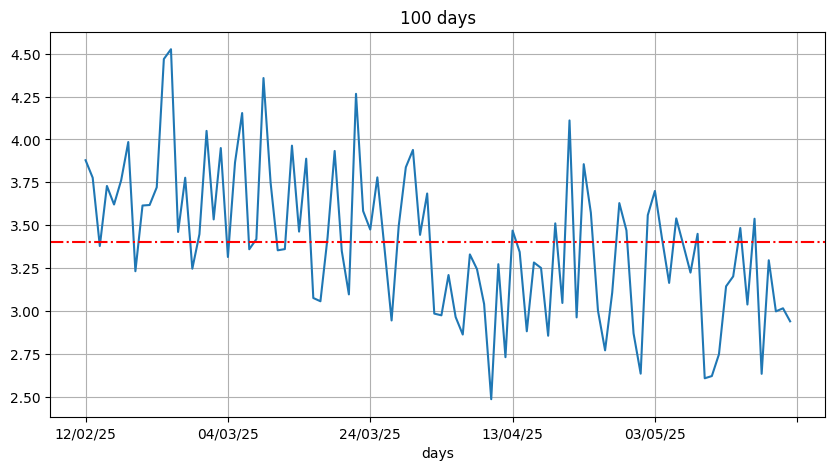

In [131]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [132]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 21:42:00, Minutes in day: 1302


In [133]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [134]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:25.61


In [135]:
end - start

85.61182737350464

In [136]:
#df = conso_day
show_tranches()

3
2025-05-22 00:00:07.450703	2025-05-22 08:16:25.115703	8h 16m 17s 	1000
2025-05-22 08:16:25.115703	2025-05-22 13:33:45.665703	5h 17m 20s 	2000
2025-05-22 13:33:45.665703	2025-05-22 21:40:36.185703	8h 6m 50s 	940


# Today

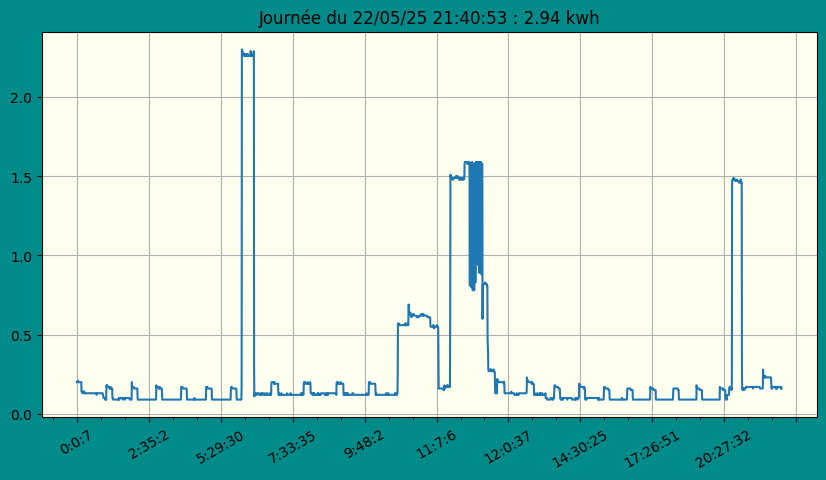

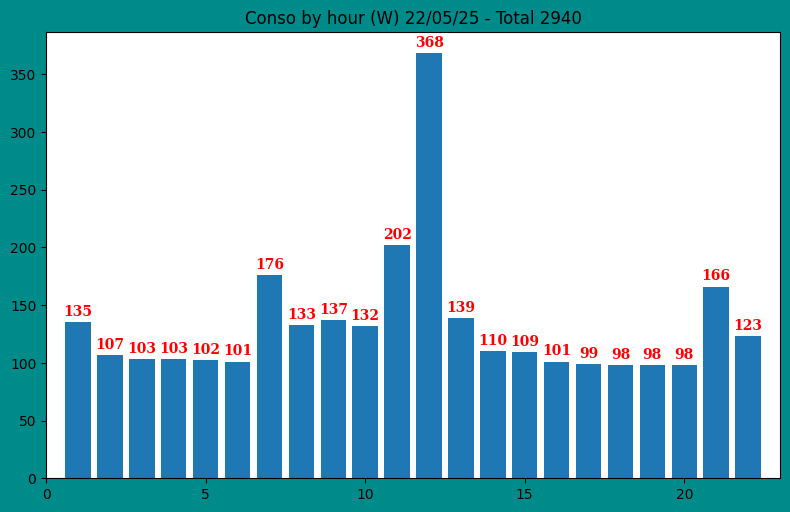

In [137]:
show(today,bgcolor='ivory')
conso_by_hour(today)

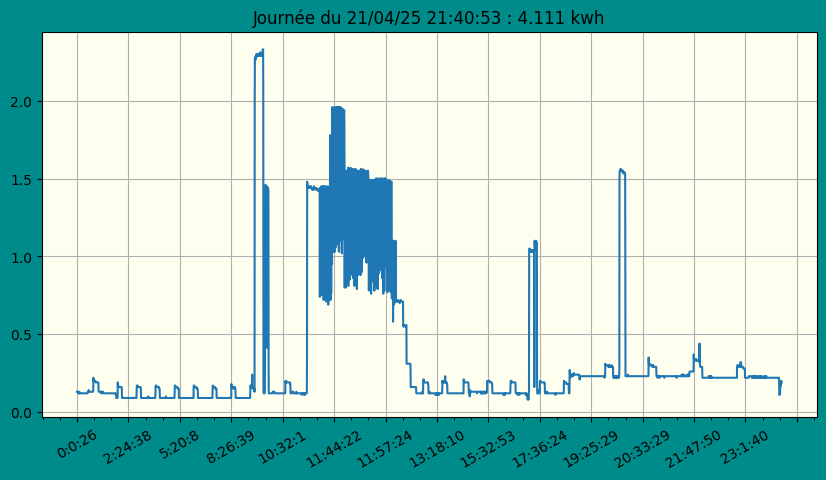

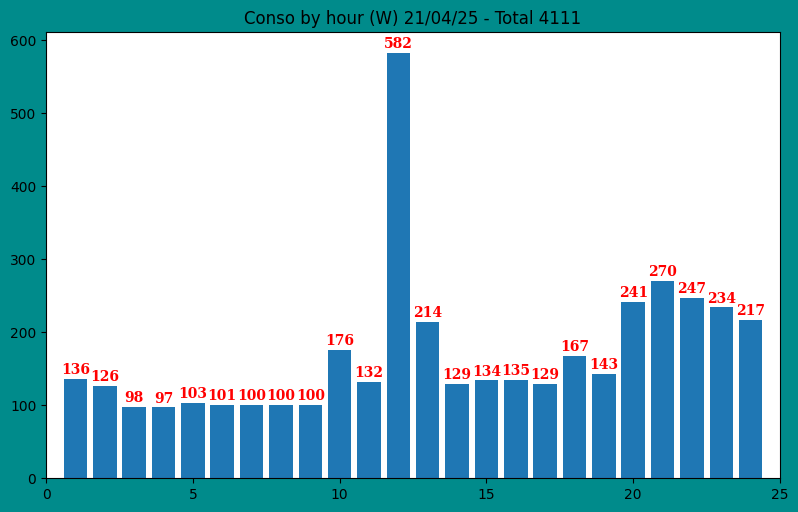

In [138]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4885)

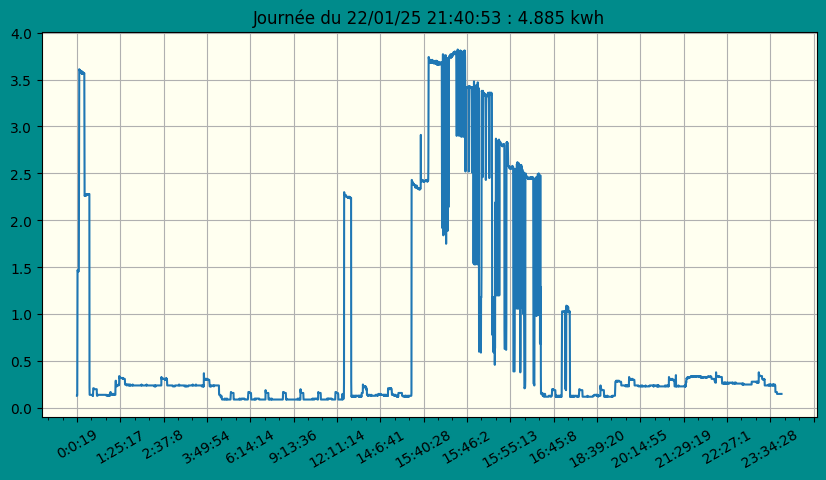

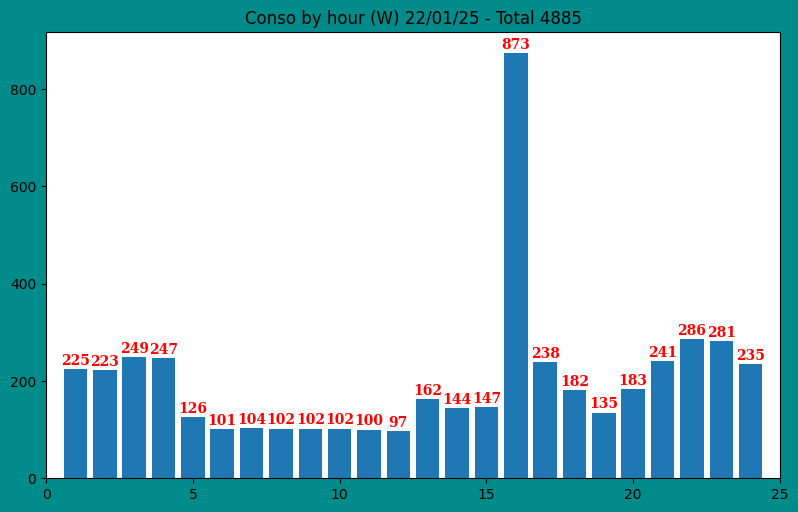

In [139]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

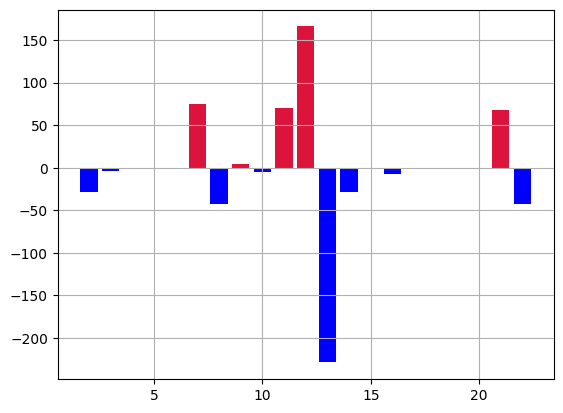

In [140]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

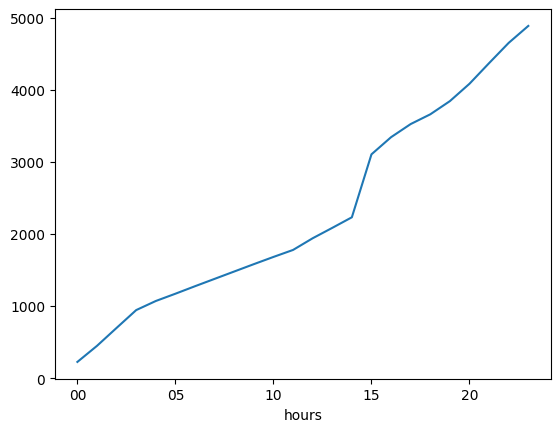

In [141]:
data.cumsum().plot()


<Axes: xlabel='hours'>

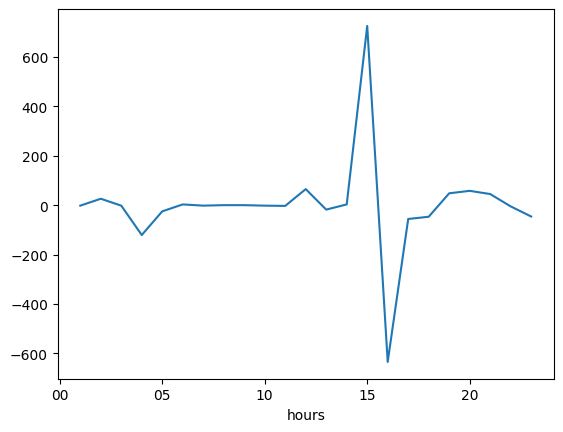

In [142]:
# evolution par heure
data.diff().plot()

In [143]:
data.diff().describe()

count     23.000000
mean       0.434783
std      209.546008
min     -635.000000
25%      -21.500000
50%       -2.000000
75%       14.500000
max      726.000000
Name: kWh, dtype: float64

<Axes: >

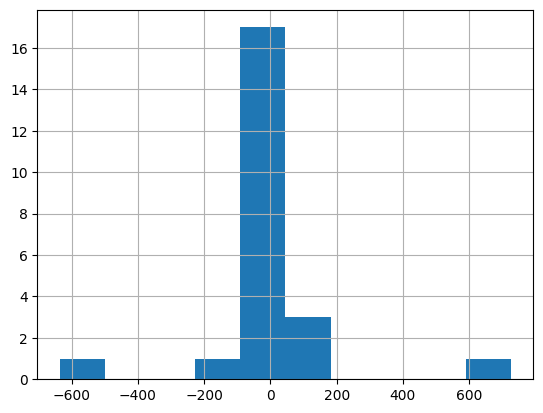

In [144]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [145]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo

# list store files csv


In [146]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

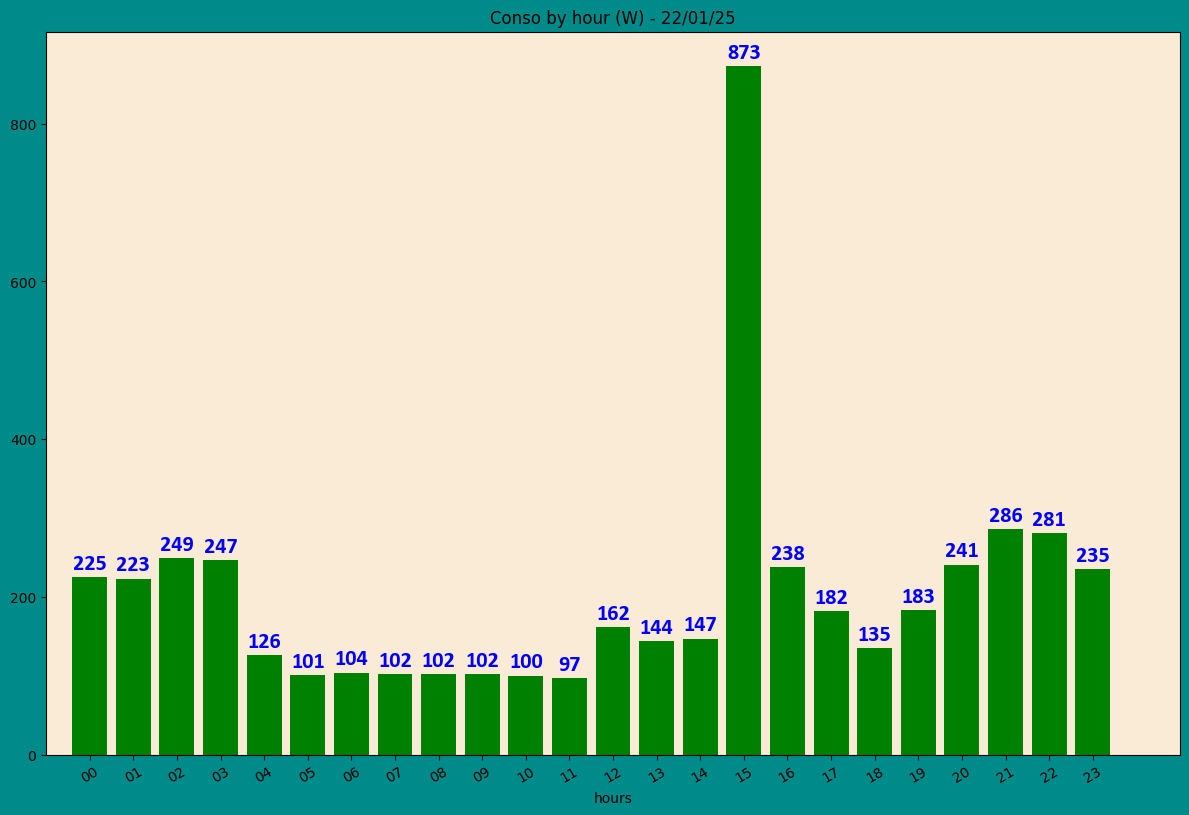

In [147]:
day,conso_byhour(day)

In [148]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


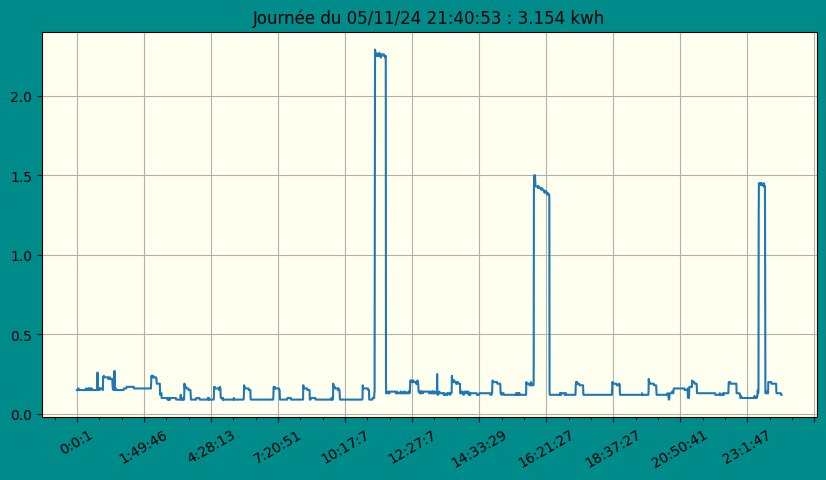

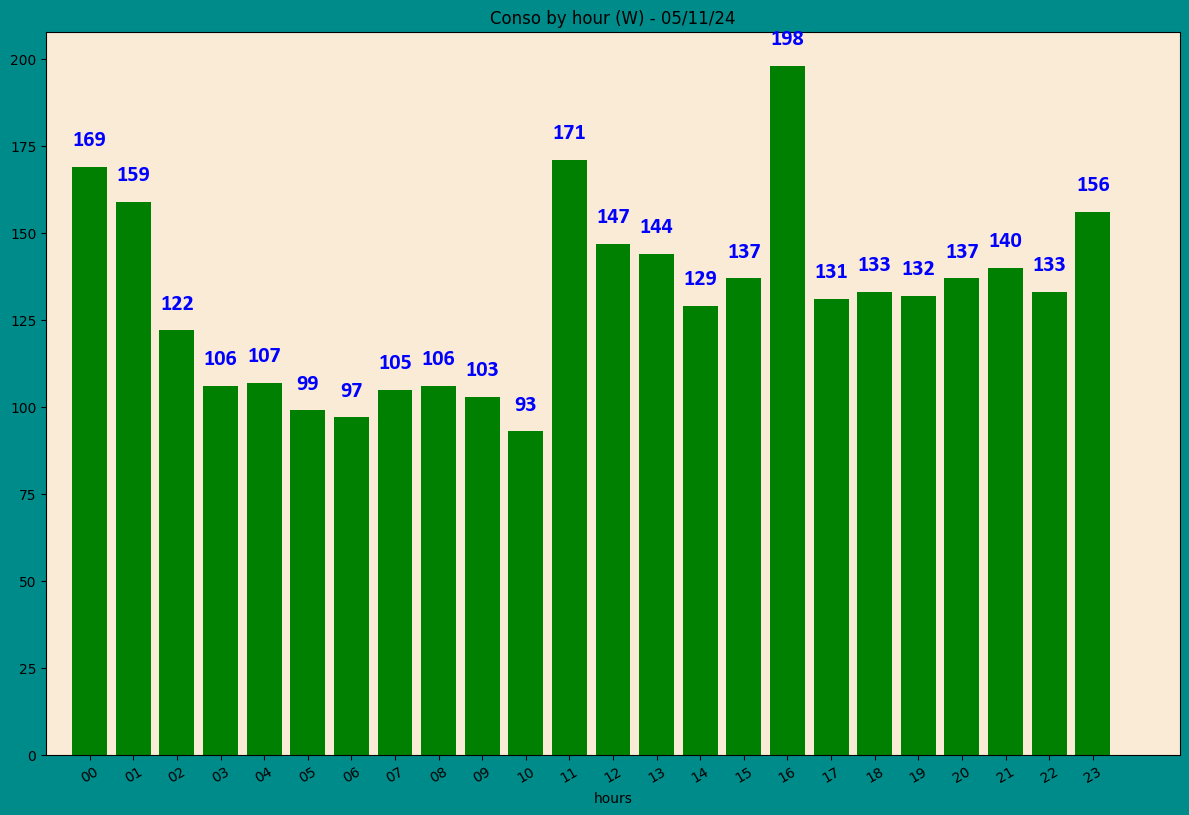

In [149]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [150]:
month

,day,hours,months,kWh
834872,01,00,2025-04,0.20
834873,01,00,2025-04,0.20
834874,01,00,2025-04,0.20
834875,01,00,2025-04,0.20
834876,01,00,2025-04,0.20
...,...,...,...,...
930650,30,23,2025-04,0.09
930651,30,23,2025-04,0.09
930652,30,23,2025-04,0.09
930653,30,23,2025-04,0.09


In [151]:
month.describe()


,kWh
count,95783.000000
mean,0.310161
std,0.548037
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

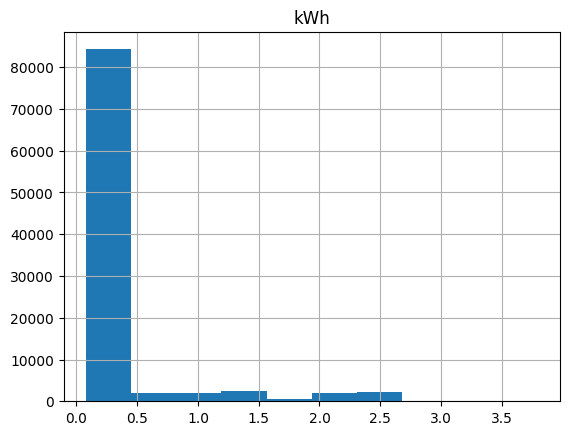

In [152]:
month.hist()

<Axes: >

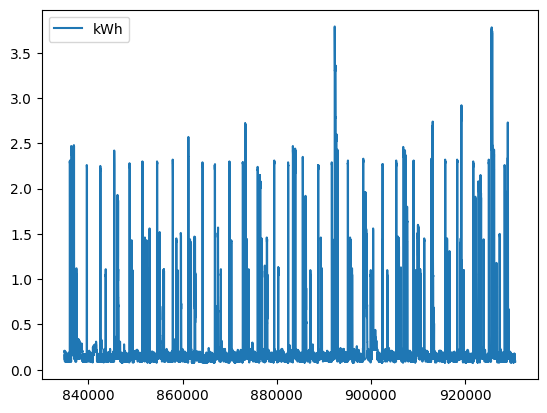

In [153]:
month.plot()

In [154]:
# index with max conso in this month
month.idxmax().kWh

np.int64(892319)

In [155]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       927785
hours     838352
months    834872
kWh       892319
dtype: int64

In [156]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [157]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
25/07/24 08      34      34   NaN   NaN
         09     112     146  78.0   NaN
         10     112     258   0.0   NaN
         11     113     371   1.0   NaN
         12     172     543  59.0   NaN
...             ...     ...   ...   ...
22/05/25 17      98    2455  -1.0  18.0
         18      98    2553   0.0  19.0
         19      98    2651   0.0  20.0
         20     166    2817  68.0  21.0
         21     123    2940 -43.0  22.0

[7238 rows x 4 columns]

In [158]:
month

,day,hours,months,kWh
834872,01,00,2025-04,0.20
834873,01,00,2025-04,0.20
834874,01,00,2025-04,0.20
834875,01,00,2025-04,0.20
834876,01,00,2025-04,0.20
...,...,...,...,...
930650,30,23,2025-04,0.09
930651,30,23,2025-04,0.09
930652,30,23,2025-04,0.09
930653,30,23,2025-04,0.09


In [159]:
month.idxmax()


day       927785
hours     838352
months    834872
kWh       892319
dtype: int64

In [160]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 892319, dtype: object

In [161]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       171
          01       127
          02       114
          03       110
          04       106
          05       103
          06       111
          07       111
          08       103
          09       104
          10       166
          11       143
          12       143
          13       138
          14       203
          15       142
          16       152
          17       186
          18       155
          19       146
          20       143
          21       172
          22       225
          23       174
Name: kWh, dtype: int64

In [162]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

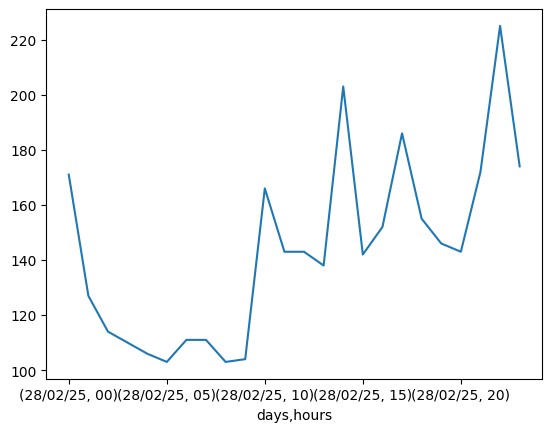

In [163]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [164]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [165]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [166]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [167]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB